# Data Preprocessing and Library loading:

In [35]:
import json, sys, time, os, copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas
import pickle

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_curve, roc_auc_score

plt.rcParams['figure.figsize'] = [6.4*2, 4.8*2]
sns.set_theme("paper")
sns.set_style(style="darkgrid")
fullDataset = True

In [36]:
jsonDir = "./jsonFiles"
numpyDir = "./numpyFiles"

fullTestSet = np.load(os.path.join(numpyDir,"fullTestSet.npy"))
errMSE = np.load(os.path.join(numpyDir,"ERROR_MAE_3D_T1.npy"))

with open(os.path.join(jsonDir,"file_list_3D_MAE.json"),"r") as f:
    fileList = json.load(f)

fileList = [x[:-8] for x in fileList]

print("Number of Files: ", len(fileList))

Number of Files:  31199


In [37]:
# Flattening Error volume 8x7x7 for RF

errFlat = np.zeros((errMSE.shape[0],errMSE.shape[1]*errMSE.shape[2]*errMSE.shape[3]))

for i in range(errMSE.shape[0]):
    errFlat[i] = errMSE[i,:,:,:].flatten()

print("Pre Flatten {} vs. Flattened {}".format(errMSE.shape,errFlat.shape))

Pre Flatten (31199, 8, 7, 7) vs. Flattened (31199, 392)


In [38]:
# Load in tags and additional meta data:

with open(os.path.join(jsonDir,"./reasons_split.json"),"r") as f: # Tags
    tagDict = json.load(f)

if not fullDataset:
    with open(os.path.join(jsonDir,"biobank_meta_float.json"),"r") as f: # Float meta data from dcm headers
        metaDict = json.load(f)
else:
    with open(os.path.join(jsonDir,"biobank_meta_full_one_hot.json"),"r") as f: # All one hot encoded meta
        metaDict = json.load(f)

with open(os.path.join(jsonDir,"Biobank_Bounding_Boxes.json"),"r") as f: # Bounding box meta data
    bBoxes = json.load(f)

In [39]:
# Sort through subj to make sure all meta data present

if fullDataset:
    keys = list(metaDict['eid'].values())
else:
    keys = list(metaDict.keys())

keys = [k for k in keys if k in bBoxes.keys()]
keys = [k for k in keys if k in fileList]

print("Number of Files with complete meta data: ", len(keys))

Number of Files with complete meta data:  31199


In [40]:
###### Find out the keys present in every single case:
if not fullDataset:
    allMetaKeys = []
    instTime = ["1","2","3","4","5","6","7"]
    for k in keys:
        for i in instTime:
            allMetaKeys.extend(list(metaDict[k][i].keys()))

    allMetaKeysSet = set(allMetaKeys)

    keysOI = []
    for k in allMetaKeysSet:
        if allMetaKeys.count(k) == (len(keys)*7):
            keysOI.append(k)
else:
    keysOI = list(metaDict.keys())

print("Meta values to use: \n\n", keysOI)

Meta values to use: 

 ['[SlicePosition_PCS]_0', '[SlicePosition_PCS]_1', '[SlicePosition_PCS]_2', 'Accession Number', 'Echo Train Length', '1', '1_1_0', '2', '3', '4', 'NONE', 'NONE_1_0', 'Algo1', 'WINDOW1', 'Echo Number(s)', 'TI_0', 'TI_1', 'TI_2', 'TI_3', 'TI_4', 'TI_5', 'TI_6', '[TimeAfterStart]_0', '[TimeAfterStart]_1', '[TimeAfterStart]_2', '[TimeAfterStart]_3', '[TimeAfterStart]_4', '[TimeAfterStart]_5', '[TimeAfterStart]_6', 'Samples per Pixel', 'ShMOLLI_192i', 'ShMOLLI_192i LIVER', '[SliceMeasurementDuration]_0', '[SliceMeasurementDuration]_1', '[SliceMeasurementDuration]_2', '[SliceMeasurementDuration]_3', '[SliceMeasurementDuration]_4', '[SliceMeasurementDuration]_5', '[SliceMeasurementDuration]_6', 'Image Position (Patient)_0', 'Image Position (Patient)_1', 'Image Position (Patient)_2', 'Largest Image Pixel Value_0', 'Largest Image Pixel Value_1', 'Largest Image Pixel Value_2', 'Largest Image Pixel Value_3', 'Largest Image Pixel Value_4', 'Largest Image Pixel Value_5', 'Lar

In [41]:
# Normalise Meta Data

for kOI in keysOI[:-1]:
    try:
        tempKeys = list(metaDict[kOI].keys())
        tempList = np.array(list(metaDict[kOI].values()))

        mean = np.mean(tempList)
        std = np.std(tempList)

        for k in tempKeys:
            metaDict[kOI][k] = (metaDict[kOI][k]-mean)/std

        tempList = np.array(list(metaDict[kOI].values()))
        mean = np.mean(tempList)
        std = np.std(tempList)
    except TypeError as e:
        print(kOI,e)


bBoxesClasses = ["Body","Liver","Lungs","Heart"]
divList = [384,288,384,288]
for k in keys:
    tempValues = {}
    for bbC in bBoxesClasses:
        try:
            res = [bbVal/divVal for bbVal,divVal in zip(bBoxes[k][bbC],divList)]
            bBoxes[k][bbC] = res
        except KeyError as e:
            pass

errFlat = (errFlat-errFlat.mean())/errFlat.std()

c:\Users\shug4421\Meta_T1\venv\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


In [42]:

# Create dataset (full one hot):
if fullDataset:
    subjLength = len(keys)
    dataLength = len(keysOI)
    bBoxesLength = 16
    errLength = errFlat.shape[1]

    ownDataset = np.zeros((subjLength,dataLength + bBoxesLength + errLength))

    k0 = list(tagDict.keys())[0]
    tags = np.zeros((subjLength,len(tagDict[k0])))

    for i,k in enumerate(keys):
        sys.stdout.write("\r[{}/{}]".format(i,len(keys)))
        metaList = []
        for kOI in keysOI:
            metaList.append(metaDict[kOI][str(i)])

        try:
            metaList.extend(bBoxes[k]["Body"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        try:
            metaList.extend(bBoxes[k]["Liver"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        try:
            metaList.extend(bBoxes[k]["Lungs"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        try:
            metaList.extend(bBoxes[k]["Heart"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        charArr = np.char.find(fileList,k)
        charIdx = np.argwhere(charArr == 0)[0,0]
        
        assert(type(charIdx) == np.int64)
        errMeta = list(errFlat[charIdx,:])

        metaList.extend(errMeta)

        ownDataset[i,:] = np.array(metaList)
        if k in tagDict.keys():
            tags[i] = np.array(tagDict[k])

    ownDataset = (ownDataset,tags)

    print("\n Meta Data for Subj0: {} \n Tag for Subj0: {}".format(ownDataset[0][0][:10],ownDataset[1][0]))

# Create dataset (float only):
else:
    subjLength = len(keys)
    dataLength = len(keysOI)*len(instTime)
    print("Data Length: {}\n".format(dataLength))
    bBoxesLength = 16
    errLength = errFlat.shape[1]

    ownDataset = np.zeros((subjLength,dataLength + bBoxesLength + errLength))

    k0 = list(tagDict.keys())[0]
    tags = np.zeros((subjLength,len(tagDict[k0])))

    for i,k in enumerate(keys):
        sys.stdout.write("\r[{}/{}]".format(i,len(keys)))
        metaList = []
        for kOI in keysOI:
            for inst in instTime:
                metaList.append(metaDict[k][inst][kOI])
        try:
            metaList.extend(bBoxes[k]["Body"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        try:
            metaList.extend(bBoxes[k]["Liver"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        try:
            metaList.extend(bBoxes[k]["Lungs"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        try:
            metaList.extend(bBoxes[k]["Heart"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        charArr = np.char.find(fileList,k)
        charIdx = np.argwhere(charArr == 0)[0,0]
        
        assert(type(charIdx) == np.int64)
        errMeta = list(errFlat[charIdx,:])

        metaList.extend(errMeta)

        ownDataset[i,:] = np.array(metaList)
        if k in tagDict.keys():
            tags[i] = np.array(tagDict[k])

    ownDataset = (ownDataset,tags)

    print("\n Meta Data for Subj0: {} \n Tag for Subj0: {}".format(ownDataset[0][0][:10],ownDataset[1][0]))

[31198/31199]
 Meta Data for Subj0: [-0.28984534  0.89438922 -0.11211638 -0.00459495         nan  0.25948737
 -0.01656941 -0.24011892 -0.05164634 -0.0064983 ] 
 Tag for Subj0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [43]:
print("Header Meta Data: {} \nBounding Box Meta Data: {} \nImage Recon Errors: {} \n".format(dataLength,bBoxesLength,errLength))

Header Meta Data: 286 
Bounding Box Meta Data: 16 
Image Recon Errors: 392 



In [79]:
tempMeta[np.isnan(tempMeta)] = 0.0

[-0.28984534  0.89438922 -0.11211638 -0.00459495         nan  0.25948737
 -0.01656941 -0.24011892 -0.05164634 -0.0064983 ]
[-0.28984534  0.89438922 -0.11211638 -0.00459495  0.          0.25948737
 -0.01656941 -0.24011892 -0.05164634 -0.0064983 ]


# Train MLP:

## All Data:

In [90]:
# Hyperparameters:

testSize = 0.1
tagNames = ['Artifacts', 'badsequence', 'Field_artefacts', 'highiron-lowt1', 'lookuptable-rip', 'm50pcfail', 'Other_Unlisted', 'pdff35', 'Rainbow', 'Segmentation_fail', 'Wrong_location', 'zeroct1']

import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):

    def __init__(self,inC,outC):
        super(MLP,self).__init__()

        self.dense1 = nn.Linear(inC,256)
        self.dense2 = nn.Linear(256,128)
        self.dense3 = nn.Linear(128,32)
        self.dense4 = nn.Linear(32,outC)

    def forward(self,x):
        x = F.relu(F.dropout(self.dense1(x)))
        x = F.relu(F.dropout(self.dense2(x)))
        x = F.relu(F.dropout(self.dense3(x)))

        x = self.dense4(x)

        return x


In [91]:
from torch.optim import Adam

x0, y0 = ownDataset

clfDict = {}

X_train, X_test, y_train, y_test = train_test_split(x0, y0,test_size=testSize)

trainDataLen = X_train.shape[0]

X_val = X_train[int(0.8*trainDataLen):,:]
y_val = y_train[int(0.8*trainDataLen):,:]

X_train = X_train[:int(0.8*trainDataLen),:]
y_train = y_train[:int(0.8*trainDataLen),:]

for idx,name in enumerate(tagNames):
    print("#"*50,"\n Training Classifier for {} \n".format(name),"#"*50)

    clf = MLP(x0.shape[1],1)
    device = torch.device("cuda:0")
    clf = clf.to(device)

    y = y_train[:,idx]
    X = X_train[:,:]

    X = torch.from_numpy(X)
    y = torch.from_numpy(y)

    X = X.float()
    y = y.float()

    y_val_idx = y_val[:,idx]
    X_val_idx = X_val[:,:]

    X_val_idx = torch.from_numpy(X_val_idx)
    y_val_idx = torch.from_numpy(y_val_idx)

    X_val_idx = X_val_idx.float()
    y_val_idx = y_val_idx.float()

    batches = np.arange(0,X_train.shape[0],10)

    optimiser = Adam(clf.parameters(),lr=1e-10)
    critertion = nn.BCEWithLogitsLoss()
    critertion.to(device)

    numEpochs = 10
    lowestLoss = 10000000000000000000.0
    for nE in range(numEpochs):
        print("\n Training: \n")
        clf.train()
        for i,num in enumerate(batches[1:]):
            sys.stdout.write("\r Epoch {}: [{}/{}]".format(nE,num,X.shape[0]))
            inputBatch = X[batches[i]:num,:]
            outputGT = y[batches[i]:num]
            outputGT.unsqueeze_(1)

            inputBatch = inputBatch.to(device)
            outputGT = outputGT.to(device)

            optimiser.zero_grad()

            outputBatch = clf(inputBatch)

            loss = critertion(outputBatch,outputGT)
            print(loss.item())
            sys.exit()

            loss.backward()

            optimiser.step()

        print("\n Validating: \n")
        clf.eval()
        with torch.no_grad():
            valLoss = 0.0
            for i,num in enumerate(batches[1:]):
                sys.stdout.write("\r Epoch {}: [{}/{}]".format(nE,num,X_val_idx.shape[0]))
                inputBatch = X_val_idx[batches[i]:num,:]
                outputGT = y_val_idx[batches[i]:num]
                outputGT.unsqueeze_(1)

                inputBatch = inputBatch.to(device)
                outputGT = outputGT.to(device)

                outputBatch = clf(inputBatch)

                loss = critertion(outputBatch,outputGT)

                valLoss += loss.item()

            valLoss /= X_val_idx.shape[0]

            if valLoss < lowestLoss:
                lowestLoss = valLoss
                clfDict[name] = clf

            print("\n Val Loss = {:.5f} \n".format(valLoss))


################################################## 
 Training Classifier for Artifacts 
 ##################################################

 Training: 

 Epoch 0: [10/22463]nan


SystemExit: 

In [84]:
loss.item()

nan

In [83]:
if type(X_test) == np.ndarray:
    X_test = torch.from_numpy(X_test)
    X_test = X_test.float()

batches = np.arange(0,X_test.shape[0],100)
sig = nn.Sigmoid().to(device)
pred = np.zeros(y_test.shape)

for idx,name in enumerate(clfDict.keys()):
    print("#"*50,"\n Predicting Classifier for {} \n".format(name),"#"*50)

    clf = clfDict[name]
    clf.eval()
    with torch.no_grad():
        for i,num in enumerate(batches[1:]):
            sys.stdout.write("\r[{}/{}]".format(num,X_test.shape[0]))
            inputBatch = X_test[batches[i]:num,:]

            inputBatch = inputBatch.to(device)
            outputGT = outputGT.to(device)

            outputBatch = clf(inputBatch)
            outputBatch = sig(outputBatch)

            outputBatch = outputBatch.cpu().numpy()

            pred[batches[i]:num,idx] = outputBatch[:,0]
    print()

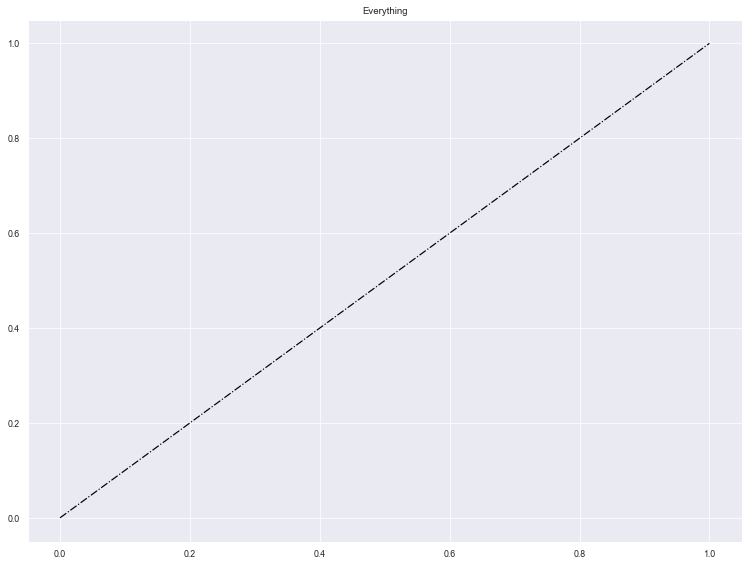

In [48]:
modelsArr = []
fprArr = []
tprArr = []

for i,name in enumerate(clfDict.keys()):
    fpr,tpr,_ = roc_curve(y_test[:,i],pred[:,i])
    auc_score = roc_auc_score(y_test[:,i],pred[:,i])

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)
df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})

plt.figure()
plt.title("Everything")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

In [ ]:
# Save Models
saveDir = "./models/MLP/All_Meta/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    pickle.dump(clfDict[name], open(os.path.join(saveDir,name,"classifier.sav"),'wb'))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

## Meta + Bboxes:

In [ ]:
x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []

for nAv in numAvgs:
        sys.stdout.write("\r[{}/{}]".format(nAv*len(tagNames)+idx,numAvgs.shape[0]*len(tagNames)))
        clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,verbose=False,n_jobs=-1)

        y = y0[:,idx]
        X = x0[:,:-errLength]

        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=testSize,random_state=42)

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        probs = clf.predict_proba(X_test)

        fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
        auc_score = roc_auc_score(y_test,probs[:,1])

        avgAUC[name].append(auc_score)

        if topAUC[name] < auc_score:
            topAUC[name] = auc_score
            clfDict[name] = clf

            metricsDict[name]["AUC"] = auc_score
            metricsDict[name]["FPR"] = fpr
            metricsDict[name]["TPR"] = tpr

In [ ]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

In [ ]:
# Plot the ROC curves for each Class (One Vs Rest)

plt.figure()
plt.title("Meta + Bounding Boxes")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

In [ ]:
# Save Models
saveDir = "./models/Random Forests/Meta_BBoxes/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    pickle.dump(clfDict[name], open(os.path.join(saveDir,name,"classifier.sav"),'wb'))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

## Meta Only:

In [ ]:
x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []

for nAv in numAvgs:
    for idx,name in enumerate(tagNames):
        sys.stdout.write("\r[{}/{}]".format(nAv*len(tagNames)+idx,numAvgs.shape[0]*len(tagNames)))
        clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,verbose=False,n_jobs=-1)

        y = y0[:,idx]
        X = x0[:,:-(bBoxesLength+errLength)]

        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=testSize,random_state=42)

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        probs = clf.predict_proba(X_test)

        fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
        auc_score = roc_auc_score(y_test,probs[:,1])

        avgAUC[name].append(auc_score)

        if topAUC[name] < auc_score:
            topAUC[name] = auc_score
            clfDict[name] = clf

            metricsDict[name]["AUC"] = auc_score
            metricsDict[name]["FPR"] = fpr
            metricsDict[name]["TPR"] = tpr

In [ ]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

In [ ]:
# Plot the ROC curves for each Class (One Vs Rest)

plt.figure()
plt.title("Meta Only")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

In [ ]:
# Save Models
saveDir = "./models/Random Forests/Meta_Only/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    pickle.dump(clfDict[name], open(os.path.join(saveDir,name,"classifier.sav"),'wb'))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

## Error Only: 

In [ ]:
x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []

for nAv in numAvgs:
    for idx,name in enumerate(tagNames):
        sys.stdout.write("\r[{}/{}]".format(nAv*len(tagNames)+idx,numAvgs.shape[0]*len(tagNames)))
        clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,verbose=False,n_jobs=-1)

        y = y0[:,idx]
        X = x0[:,-errLength:]

        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=testSize,random_state=42)

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        probs = clf.predict_proba(X_test)

        fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
        auc_score = roc_auc_score(y_test,probs[:,1])

        avgAUC[name].append(auc_score)

        if topAUC[name] < auc_score:
            topAUC[name] = auc_score
            clfDict[name] = clf

            metricsDict[name]["AUC"] = auc_score
            metricsDict[name]["FPR"] = fpr
            metricsDict[name]["TPR"] = tpr

In [ ]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

In [ ]:
# Plot the ROC curves for each Class (One Vs Rest)

plt.figure()
plt.title("Error Only")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

In [ ]:
# Save Models
saveDir = "./models/Random Forests/Error_Only/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    pickle.dump(clfDict[name], open(os.path.join(saveDir,name,"classifier.sav"),'wb'))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

## Error + BBoxes:

In [ ]:
x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []

for nAv in numAvgs:
    for idx,name in enumerate(tagNames):
        sys.stdout.write("\r[{}/{}]".format(nAv*len(tagNames)+idx,numAvgs.shape[0]*len(tagNames)))
        clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,verbose=False,n_jobs=-1)

        y = y0[:,idx]
        X = x0[:,-(bBoxesLength+errLength):]

        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=testSize,random_state=42)

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        probs = clf.predict_proba(X_test)

        fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
        auc_score = roc_auc_score(y_test,probs[:,1])

        avgAUC[name].append(auc_score)

        if topAUC[name] < auc_score:
            topAUC[name] = auc_score
            clfDict[name] = clf

            metricsDict[name]["AUC"] = auc_score
            metricsDict[name]["FPR"] = fpr
            metricsDict[name]["TPR"] = tpr

In [ ]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

In [ ]:
# Plot the ROC curves for each Class (One Vs Rest)

plt.figure()
plt.title("Error + Bounding Boxes")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

In [ ]:
# Save Models
saveDir = "./models/Random Forests/Error_BBoxes/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    pickle.dump(clfDict[name], open(os.path.join(saveDir,name,"classifier.sav"),'wb'))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

# AUC Comparisons:

In [ ]:
import seaborn as sns
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

loadDir = "./models/Random Forests/"

ignoreList = ["Float","Float_Categorical"]
rfList = [x for x in os.listdir(loadDir) if x not in ignoreList]

fullDict = {}
for fol in rfList:
    fullDict[fol] = {}
    with open(os.path.join(loadDir,fol,"metrics.json")) as f:
        metrics = json.load(f)
    for k1 in metrics.keys():
        avgAUC = []
        for k2 in metrics[k1].keys():
            avgAUC.append(metrics[k1][k2])
        fullDict[fol][k1] = np.mean(avgAUC)

df = pd.DataFrame(fullDict)
print(df)

plt.figure()
sns.lineplot(data=df,markers=True)
plt.xlabel("Class")
plt.ylabel("AUC of ROC")
plt.xticks(rotation=45)
plt.show()

In [ ]:
x0, y0 = ownDataset

newY = np.zeros(y0.shape[0])
for i in range(y0.shape[0]):
    if np.sum(y0[i,:]) >= 1:
        newY[i] = 1

y0 = newY

modelsArr = []
fprArr = []
tprArr = []
clfDict = {}

names = ["Everything","Meta+Bboxes","Meta","Error"]
features = [(0,-1),(0,-errFlat.shape[1]),(0,-(16+errFlat.shape[1])),(-errFlat.shape[1],-1)]

for name,(m,n) in zip(names,features):
    clf = RandomForestClassifier(n_estimators=100,max_depth=10,verbose=False,n_jobs=-1)

    y = y0
    if n == -1:
        X = x0[:,m:]
    else:
        X = x0[:,m:n]

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.4,random_state=42)

    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    probs = clf.predict_proba(X_test)

    fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
    auc_score = roc_auc_score(y_test,probs[:,1])

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    clfDict[name] = clf

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})

plt.figure()
plt.title("Include_Exclude")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

# Feature Importance:

In [ ]:

featuresPlot = {}
for name in tagNames:
    featuresPlot[name] = []

for idx,name in enumerate(tagNames):
    print("#"*50)
    print(name)
    print("#"*50)

    clf = clfDict[name]
    instCnt = 0
    featCnt = -1
    for i,fImp in enumerate(clf.feature_importances_):
        if i % 7 == 0:
            instCnt = 0
            featCnt += 1
        if fImp > 0.005:
            featuresPlot[name].append((keysOI[featCnt],instTime[instCnt]))
            print("{},\t {}, \t\t\t {}".format(keysOI[featCnt],instTime[instCnt],fImp))
        instCnt += 1
    print("#"*50)


In [ ]:
name = "Segmentation_fail"

features = [x[0] for x in featuresPlot['Artifacts']]
features = list(set(features))

for topFeature in features:
    metaList = []
    instTimeList = []
    tagListStr = []
    for i,k in enumerate(metaDict.keys()):
        for inst in instTime:
            instTimeList.append(inst)
            metaList.append(metaDict[k][inst][topFeature])
            if k in tagDict.keys():
                issues = tagDict[k]
                if issues[idx] == 1:
                    tagListStr.append("Exclude")
                else:
                    tagListStr.append("Include")
            else:
                tagListStr.append("Include")

    d = {topFeature:metaList,"Instance":instTimeList,"Class":tagListStr}
    df = pandas.DataFrame(data=d)

    sns.violinplot(x="Instance",y=topFeature,hue="Class",split=False,data=df)
    plt.show()
